In [1]:
import os
import sys
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
	sys.path.append(nb_dir)

In [2]:
import torch
import torch.nn as nn
from torch.optim.radam import RAdam

import matplotlib.pyplot as plt
import random
from tqdm import trange

from general_utils import AttrDict
from reward_induced.src.reward_predictor_model import RewardPredictorModel, R_CLASSES_BASE
from sprites_datagen.moving_sprites import MovingSpriteDataset
from sprites_datagen.rewards import *


/home/thisiswooyeol/anaconda3/envs/2024Spring/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
spec = AttrDict(
        resolution=64,
        max_seq_len=30,
        max_speed=0.05,      # total image range [0, 1]
        obj_size=0.2,       # size of objects, full images is 1.0
        shapes_per_traj=4,      # number of shapes per trajectory
        rewards=[AgentXReward, AgentYReward, TargetXReward, TargetYReward],
    )

In [4]:
dataset = MovingSpriteDataset(spec)
dataset[0]['rewards']

{'agent_x': array([0.89554626, 0.8999031 , 0.8953525 , 0.89080185, 0.8862512 ,
        0.8817006 , 0.87714994, 0.8725993 , 0.86804867, 0.86349803,
        0.8589474 , 0.85439676, 0.8498461 , 0.8452955 , 0.84074485,
        0.8361942 , 0.8316436 , 0.82709295, 0.8225423 , 0.8179917 ,
        0.81344104, 0.8088904 , 0.80433977, 0.79978913, 0.7952385 ,
        0.79068786, 0.7861372 , 0.7815866 , 0.777036  , 0.7724854 ],
       dtype=float32),
 'agent_y': array([0.2537266 , 0.24993488, 0.24614315, 0.24235143, 0.2385597 ,
        0.23476796, 0.23097624, 0.2271845 , 0.22339277, 0.21960105,
        0.21580932, 0.2120176 , 0.20822586, 0.20443413, 0.2006424 ,
        0.19685067, 0.19305894, 0.18926722, 0.18547548, 0.18168376,
        0.17789203, 0.1741003 , 0.17030858, 0.16651684, 0.1627251 ,
        0.15893339, 0.15514165, 0.15134993, 0.1475582 , 0.14376646],
       dtype=float32),
 'target_x': array([0.25058267, 0.29638642, 0.34219018, 0.38799393, 0.43379772,
        0.47960147, 0.5254052 , 0.

# Train reward-induced representations with **RPM image encoder**

In [5]:
# some hyperparameters
image_shape = (3, 64, 64)
n_frames = 10  # number of conditioning frames
T_future = 20  # number of future frames to predict rewards for

lr = 1e-3
n_iter = 10_000
log_interval = 1_000

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [6]:
# # DEBUG - check computation graph of the model
# os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz/bin/'

# from torchviz import make_dot

# model = RewardPredictorModel(image_shape, n_frames, T_future).to(device)
# image = dataset[0]['images']
# image = torch.tensor(image).to(device)
# pred_rewards = model(image[:n_frames].unsqueeze(0),
#                      image[n_frames:].unsqueeze(0))['agent_x']

# make_dot(pred_rewards, params=dict(model.named_parameters())).render('RPM_comp_graph', format='png')
# make_dot(pred_rewards, params=dict(model.named_parameters()), show_attrs=True, show_saved=True).render('RPM_comp_graph_back_prop', format='png')

In [7]:
def train_RPM(model, dataset, loss_fn, optimizer, device, is_complete=True):
	losses = []
	model.to(device)
	print(f'[INFO] Training complete reward predictor model on device: {device} ...')

	for itr in trange(n_iter):
		# always call `gen_trajectory` method regardless of `itr`
		data = dataset[itr]
		images = torch.tensor(data.images).to(device)
		rewards = {k: torch.tensor(v, dtype=torch.float32, device=device) for k, v in data.rewards.items()}

		# considering incomplete reward annotations
		reward_type_list = random.sample(R_CLASSES_BASE, k=3) if not is_complete else R_CLASSES_BASE

		# predict rewards with RPM
		pred_rewards = model(
			frames=images.to(device),
			reward_type_list=reward_type_list
		)

		# compute loss for each reward type
		loss = 0
		for reward_type, pred_reward in pred_rewards.items():
			reward = rewards[reward_type][-T_future:]
			loss += loss_fn(pred_reward, reward)

		optimizer.zero_grad()
		loss.backward()
		optimizer.step()

		losses.append(loss.item())
		if (itr+1) % log_interval == 0:
			print(f'[{itr+1} / {n_iter}] RPM loss: {loss.item()}')

	return losses

In [8]:
def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

### (a) Train with complete reward annotation

In [9]:
model = RewardPredictorModel(image_shape, n_frames, T_future)
loss_fn = nn.MSELoss()

optimizer = RAdam(model.parameters(), lr=lr)

In [10]:
losses_complete_reward = train_RPM(model, dataset, loss_fn, optimizer, device, is_complete=True)

[INFO] Training complete reward predictor model on device: cuda ...


 10%|█         | 1006/10000 [00:22<03:04, 48.63it/s]

[1000 / 10000] RPM loss: 0.1203579232096672


 20%|██        | 2006/10000 [00:45<02:47, 47.83it/s]

[2000 / 10000] RPM loss: 0.13353723287582397


 30%|███       | 3005/10000 [01:09<03:05, 37.76it/s]

[3000 / 10000] RPM loss: 0.05492962896823883


 40%|████      | 4005/10000 [01:33<02:16, 43.84it/s]

[4000 / 10000] RPM loss: 0.1704491674900055


 50%|█████     | 5008/10000 [01:57<01:53, 43.83it/s]

[5000 / 10000] RPM loss: 0.12763212621212006


 60%|██████    | 6005/10000 [02:22<01:32, 43.38it/s]

[6000 / 10000] RPM loss: 0.14884355664253235


 70%|███████   | 7004/10000 [02:46<01:10, 42.42it/s]

[7000 / 10000] RPM loss: 0.21279624104499817


 80%|████████  | 8006/10000 [03:11<00:45, 43.87it/s]

[8000 / 10000] RPM loss: 0.06836555153131485


 90%|█████████ | 9004/10000 [03:36<00:23, 42.60it/s]

[9000 / 10000] RPM loss: 0.11644643545150757


100%|██████████| 10000/10000 [04:01<00:00, 41.37it/s]

[10000 / 10000] RPM loss: 0.06796806305646896


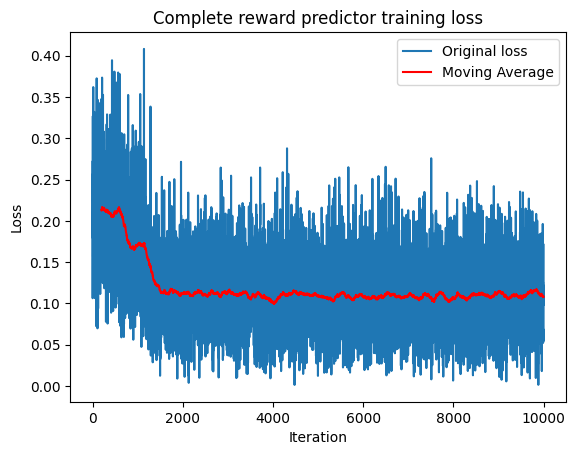

In [11]:
# Visualize the losses
window_size = 200
ma_losses = moving_average(losses_complete_reward, window_size)

plt.plot(losses_complete_reward, label='Original loss')
plt.plot(np.arange(window_size-1, len(ma_losses)+window_size-1), ma_losses, label='Moving Average', color='red')

plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Complete reward predictor training loss')
plt.legend()
plt.show()

In [12]:
PATH = 'models/complete_RPM_1e-3_1M.pth'
torch.save(model.state_dict(), PATH)

In [13]:
model = RewardPredictorModel(image_shape, n_frames, T_future)
model.load_state_dict(torch.load(PATH))  # test save and load

<All keys matched successfully>

### (b) Train with incomplete reward annotation

In [14]:
model = RewardPredictorModel(image_shape, n_frames, T_future)
loss_fn = nn.MSELoss()

optimizer = RAdam(model.parameters(), lr=lr)

In [15]:
losses_incomplete_reward = train_RPM(model, dataset, loss_fn, optimizer, device, is_complete=False)

[INFO] Training complete reward predictor model on device: cuda ...


 10%|█         | 1007/10000 [00:26<03:30, 42.63it/s]

[1000 / 10000] RPM loss: 0.10806643962860107


 20%|██        | 2006/10000 [00:52<03:03, 43.67it/s]

[2000 / 10000] RPM loss: 0.14037159085273743


 30%|███       | 3009/10000 [01:17<02:39, 43.92it/s]

[3000 / 10000] RPM loss: 0.10476796329021454


 40%|████      | 4008/10000 [01:41<01:49, 54.71it/s]

[4000 / 10000] RPM loss: 0.056270770728588104


 50%|█████     | 5005/10000 [02:03<01:43, 48.48it/s]

[5000 / 10000] RPM loss: 0.04463191330432892


 60%|██████    | 6004/10000 [02:27<01:47, 37.12it/s]

[6000 / 10000] RPM loss: 0.07785970717668533


 70%|███████   | 7003/10000 [02:46<01:10, 42.34it/s]

[7000 / 10000] RPM loss: 0.017421314492821693


 80%|████████  | 8011/10000 [03:04<00:34, 57.32it/s]

[8000 / 10000] RPM loss: 0.003774096956476569


 90%|█████████ | 9006/10000 [03:21<00:19, 51.35it/s]

[9000 / 10000] RPM loss: 0.09568097442388535


100%|██████████| 10000/10000 [03:42<00:00, 44.93it/s]

[10000 / 10000] RPM loss: 0.10576456785202026


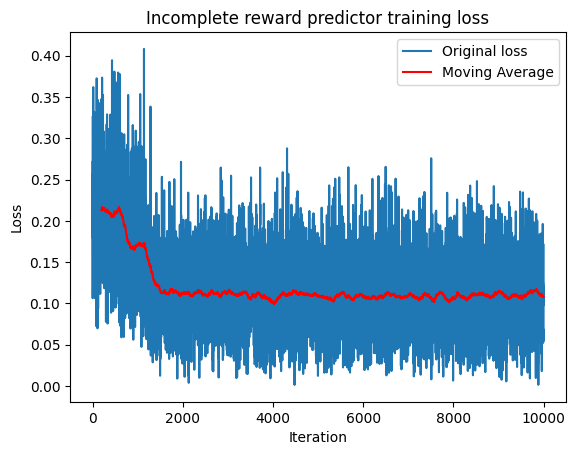

In [16]:
# Visualize the losses
window_size = 200
ma_losses = moving_average(losses_complete_reward, window_size)

plt.plot(losses_complete_reward, label='Original loss')
plt.plot(np.arange(window_size-1, len(ma_losses)+window_size-1), ma_losses, label='Moving Average', color='red')

plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Incomplete reward predictor training loss')
plt.legend()
plt.show()

In [17]:
PATH = 'models/incomplete_RPM_1e-3_1M.pth'
torch.save(model.state_dict(), PATH)

In [18]:
model = RewardPredictorModel(image_shape, n_frames, T_future)
model.load_state_dict(torch.load(PATH))  # test save and load

<All keys matched successfully>